In [1]:
import pandas as pd
import numpy as np

In [2]:
sample_data = pd.read_csv('../Railway_Network_RSP_Old/data/month_data.csv', delimiter=';',encoding='utf-8')  # or 'utf-8'
print(sample_data.columns.tolist())

['Tåguppdrag', 'Datum_PAU', 'Tågslag', 'Tågsort', 'UppehållstypAvgång', 'UppehållstypAnkomst', 'AktivitetskodAvgång', 'AktivitetskodBeskrivningAvgång', 'AktivitetskodAnkomst', 'AktivitetskodBeskrivningAnkomst', 'DelSträckanummer', 'Förstaplatssignatur_för_Uppdrag', 'Sistaplatssignatur_för_Uppdrag', 'Avgångsplats', 'Avgångsplatssignatur', 'Ankomstplats', 'Ankomstplatssignatur', 'PlanAvgTid', 'PlanAnkTid', 'UtfAnkTid', 'UtfAvgTid', 'PlanAnkTid_vid_AvgPlats', 'UtfAnkTid_vid_AvgPlats', 'PlanUppehållstidAvgång', 'UtfUppehållstidAvgång', 'PlanGångtid', 'UtfGångtid', 'FörseningGångtid', 'AvgFörsening', 'AnkFörsening', 'FörseningUppehållAvgång']


In [3]:
# Get the true start stations (where UppehållstypAvgång == "Första")
start_stations = sample_data[sample_data['UppehållstypAvgång'] == 'Första'][['Tåguppdrag', 'Förstaplatssignatur_för_Uppdrag', 'Datum_PAU']]

# Get the true end stations (where UppehållstypAnkomst == "Sista")
end_stations = sample_data[sample_data['UppehållstypAnkomst'] == 'Sista'][['Tåguppdrag', 'Sistaplatssignatur_för_Uppdrag']]

# Combine them (this assumes each journey has exactly one start and one end record)
journeys = pd.merge(start_stations, end_stations, on='Tåguppdrag')

# Count journeys between station pairs
journey_counts = journeys.groupby(['Förstaplatssignatur_för_Uppdrag', 'Sistaplatssignatur_för_Uppdrag']).size().reset_index(name='Count')
journey_counts = journey_counts.sort_values('Count', ascending=False)

print(journey_counts)

     Förstaplatssignatur_för_Uppdrag Sistaplatssignatur_för_Uppdrag  Count
258                              Cst                           Arnn  73352
26                              Arnn                            Cst  73321
269                              Cst                            Hgl  55075
747                              Hgl                            Cst  53556
514                                G                             Än  41475
...                              ...                            ...    ...
1479                              My                             Gi      1
809                               Hm                           Hbgb      1
540                               Gk                            Krd      1
1443                              Mr                             Rs      1
1453                             Mra                            Khn      1

[2442 rows x 3 columns]


In [4]:
#get full journey path
# Get all stations visited by each train in order
train_paths = (
    sample_data.sort_values(['Tåguppdrag', 'DelSträckanummer'])
    .groupby('Tåguppdrag')['Ankomstplatssignatur']
    .apply(lambda x: tuple(x))
    .reset_index(name='Path')
)

# Add start and end stations
train_paths['Start'] = train_paths['Path'].str[0]
train_paths['End'] = train_paths['Path'].str[-1]

In [5]:
#find unique routes
# Count how many trains take each unique path between start and end stations
path_counts = (
    train_paths.groupby(['Start', 'End', 'Path'])
    .size()
    .reset_index(name='Train_Count')
    .sort_values(['Start', 'End', 'Train_Count'], ascending=[True, True, False])
)

print(path_counts.head(10))

  Start   End                                               Path  Train_Count
0     A     F                      (A, Agg, Vgå, Hr, Kä, Fby, F)            1
1     A   Sär  (A, Bgs, Vbd, Ns, Ndv, Fd, Sn, Lr, Asd, Apn, J...            1
2   Aal  Hbgb                 (Aal, Hlp, Ka, Öda, Mia, Hb, Hbgb)            1
3   Aal   Mia                           (Aal, Hlp, Ka, Öda, Mia)            1
4   Acm  Avky  (Acm, Acm, Acm, Acm, Acm, Skä, Skä, Skä, Skä, ...            1
5   Acm   Blg  (Acm, Acm, Acm, Acm, Acm, Acm, Acm, Acm, Acm, ...            1
6   Acm   Blg  (Acm, Acm, Acm, Acm, Snb, Snb, Snb, Snb, Hdm, ...            1
7   Acm   Blg  (Acm, Ju, Avky, Snb, Hdm, Vhy, St, Gtf, Sau, Blg)            1
8   Acm   Blg            (Acm, Snb, Hdm, Vhy, St, Gtf, Sau, Blg)            1
9   Acm   Gså  (Acm, Acm, Acm, Snb, Snb, Snb, Hdm, Hdm, Vhy, ...            1


In [6]:
# Step 1: Get unique paths per train per day
unique_daily_paths = (
    sample_data.sort_values(['Tåguppdrag', 'Datum_PAU', 'DelSträckanummer'])
    .groupby(['Tåguppdrag', 'Datum_PAU'])['Ankomstplatssignatur']
    .apply(lambda x: tuple(x))
    .reset_index(name='Path')
    .drop_duplicates(['Tåguppdrag', 'Path'])  # Remove duplicate paths for same train
)

# Step 2: Add start and end stations
unique_daily_paths['Start'] = unique_daily_paths['Path'].apply(lambda x: x[0])
unique_daily_paths['End'] = unique_daily_paths['Path'].apply(lambda x: x[-1])

# Step 3: Count distinct paths per OD pair
od_path_counts = (
    unique_daily_paths.groupby(['Start', 'End'])
    .agg(Unique_Paths=('Path', 'nunique'))
    .reset_index()
)

# Step 4: Filter for OD pairs with >2 path variations
multi_path_routes = od_path_counts[od_path_counts['Unique_Paths'] > 2]

# Step 5: Get example paths for these OD pairs
example_paths = (
    unique_daily_paths[unique_daily_paths.set_index(['Start', 'End']).index.isin(
        multi_path_routes.set_index(['Start', 'End']).index)]
    .groupby(['Start', 'End'])['Path']
    .unique()
    .reset_index(name='Path_Variations')
)

# Merge with the counts
result = pd.merge(
    multi_path_routes,
    example_paths,
    on=['Start', 'End'],
    how='left'
)

# Convert paths to readable strings and filter out single-station paths
result['Path_Variations_Str'] = result['Path_Variations'].apply(
    lambda x: [' → '.join(p) for p in x if len(p) > 1]  # Remove single-station paths
)

# Filter out OD pairs that ended up with ≤2 paths after cleaning
result = result[result['Path_Variations_Str'].apply(len) > 2]

# Final output
print(result[['Start', 'End', 'Unique_Paths', 'Path_Variations_Str']])

    Start   End  Unique_Paths  \
0     Acm  Avky            13   
1     Acm   Blg             4   
2     Ahm     N             5   
3     Ahm    Sy             6   
4      Al    Fv            12   
..    ...   ...           ...   
558   Öte  Brny             3   
559   Övn    Cr            34   
560   Övn  Hrbg             3   
561   Övn   Mgb            14   
562   Övn   Trg            14   

                                   Path_Variations_Str  
0    [Acm → Pöb → Gk → Snb → Hdm → Or → Vhy → Gsv →...  
1    [Acm → Ju → Snb → Avky → Hdm → Vhy → St → Gtf ...  
2    [Ahm → Gt → Sä → Bdf → Utp → Utp → Bdf → Sä → ...  
3    [Ahm → Öb → Ms → Sä → Utp → Kla → Hpbg → Bdf →...  
4    [Al → Feb → Ålg → Blv → Jbk → Åk → Arb → Åkn →...  
..                                                 ...  
558  [Öte → Dån → Rön → Gau → Södy → Tu → Uts → Tul...  
559  [Övn → Tri → M → Rog → Mpb → Mgb → Al → Fsb → ...  
560  [Övn → Svö → Rog → Ög → Vid → Mpb → Lrp → Fsb ...  
561  [Övn → Svö → Rog → Ög → Mpb 

In [7]:
# First get all unique paths between Acm and Blg
acm_blg_paths = (
    sample_data.sort_values(['Tåguppdrag', 'Datum_PAU', 'DelSträckanummer'])
    .groupby(['Tåguppdrag', 'Datum_PAU'])['Ankomstplatssignatur']
    .apply(lambda x: tuple(x))
    .reset_index(name='Path')
    .assign(Start=lambda x: x['Path'].apply(lambda p: p[0]),
            End=lambda x: x['Path'].apply(lambda p: p[-1]))
    .query("Start == 'Acm' and End == 'Avky'")
)

# Get the unique path variations
unique_paths = acm_blg_paths['Path'].unique()

print(f"Found {len(unique_paths)} unique paths between Acm and Blg:")
for i, path in enumerate(unique_paths, 1):
    print(f"Path {i}: {' → '.join(path)}")

# Get all train numbers that follow these paths
relevant_trains = acm_blg_paths['Tåguppdrag'].unique()

# Filter original dataset for these trains and routes
acm_blg_full_details = (
    sample_data[sample_data['Tåguppdrag'].isin(relevant_trains)]
    .sort_values(['Tåguppdrag', 'Datum_PAU', 'DelSträckanummer'])
    .assign(Start=lambda x: x.groupby(['Tåguppdrag', 'Datum_PAU'])['Ankomstplatssignatur'].transform('first'),
            End=lambda x: x.groupby(['Tåguppdrag', 'Datum_PAU'])['Ankomstplatssignatur'].transform('last'))
    .query("Start == 'Acm' and End == 'Avky'")
)

# Add path identification
acm_blg_full_details['Path'] = (
    acm_blg_full_details.groupby(['Tåguppdrag', 'Datum_PAU'])['Ankomstplatssignatur']
    .transform(lambda x: tuple(x))
)

# Save to CSV
acm_blg_full_details.to_csv('acm_to_blg_all_paths_details.csv', index=False)

print(f"\nSaved full details of {len(acm_blg_full_details)} records to 'acm_to_blg_all_paths_details.csv'")
print(f"Contains {len(relevant_trains)} unique trains following these routes")

Found 13 unique paths between Acm and Blg:
Path 1: Acm → Pöb → Gk → Snb → Hdm → Or → Vhy → Gsv → Sär → St → Gtf → Sel → P → Sau → Jv → Blg → J → Apn → Asd → Lr → Sn → Fd → Ndv → Ns → Vbd → Bgs → A → Agg → Vgå → Hr → Kä → Fby → F → Ss → Rmtp → Sk → Vä → Mh → T → Sle → Äl → Gdö → Fa → Lå → Lln → Vt → Öj → Täl → Hrbg → Hpbg → Kla → Ms → Öb → Ör → Hsa → Er → Fv → Slg → Sba → Nkt → Krn → Skb → Dn → Fgc → Snt → Kbn → Hma → Avky
Path 2: Acm → Pöb → Snb → Gk → Hdm → Or → Vhy → Gsv → Säv → St → Sel → Gtf → P → Sau → Blg → Jv → J → Apn → Asd → Lr → Sn → Fd → Ndv → Ns → Vbd → Bgs → A → Agg → Vgå → Hr → Kä → Fby → F → Ss → Rmtp → Sk → Vä → Mh → T → Sle → Äl → Gdö → Fa → Lå → Lln → Vt → Öj → Täl → Hrbg → Hpbg → Kla → Ms → Öb → Ör → Hsa → Er → Fv → Slg → Sba → Nkt → Krn → Skb → Dn → Fgc → Snt → Kbn → Hma → Avky
Path 3: Acm → Pöb → Gk → Snb → Or → Hdm → Vhy → Gsv → Sär → St → Gtf → Sel → P → Sau → Jv → Blg → J → Apn → Asd → Lr → Sn → Fd → Ndv → Ns → Vbd → Bgs → A → Agg → Vgå → Hr → Kä → Fby → F → Ss 

In [26]:
# Compute average delay per path
path_avg_delay = (
    acm_blg_full_details.groupby('Path')['AvgFörsening']
    .mean()
    .to_dict()
)

# Compute average delay per OD pair
od_avg_delay = (
    acm_blg_full_details.groupby(['Start', 'End'])['AvgFörsening']
    .mean()
    .to_dict()
)

# Global average delay
global_avg_delay = acm_blg_full_details['AvgFörsening'].mean()


In [27]:
def impute_avg_forsening(row):
    if not pd.isna(row['AvgFörsening']):
        return row['AvgFörsening']
    
    path_key = row['Path']
    od_key = (row['Start'], row['End'])

    if path_key in path_avg_delay:
        return path_avg_delay[path_key]
    elif od_key in od_avg_delay:
        return od_avg_delay[od_key]
    else:
        return global_avg_delay


In [29]:
#apply the imputation
acm_blg_full_details['AvgFörsening_Imputed'] = acm_blg_full_details.apply(impute_avg_forsening, axis=1)

# Save the cleaned dataset with imputed delays
acm_blg_full_details.to_csv('acm_to_blg_corrected_delays.csv', index=False)

print("Saved cleaned dataset with imputed delays to 'acm_to_blg_corrected_delays.csv'")


Saved cleaned dataset with imputed delays to 'acm_to_blg_corrected_delays.csv'


C:\Users\uocja\AppData\Local\Temp\ipykernel_5756\2810614175.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


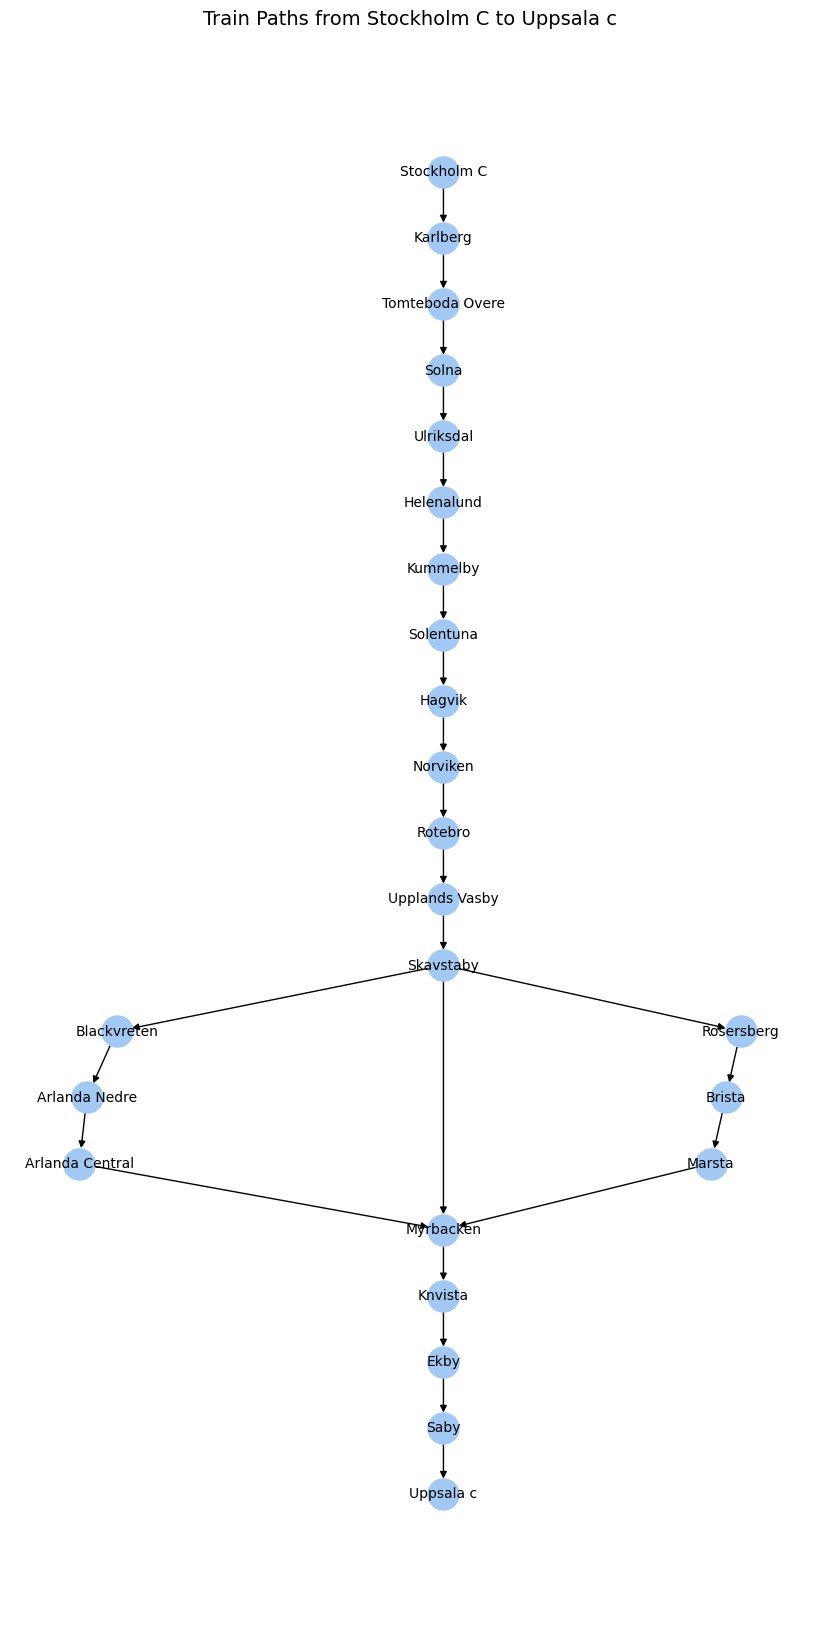

In [5]:
import matplotlib.pyplot as plt
import networkx as nx

# Install pygraphviz if needed:
# pip install pygraphviz

# --- Define your paths ---
paths = [
    ['Stockholm C', 'Karlberg', 'Tomteboda Overe', 'Solna', 'Ulriksdal', 'Helenalund', 'Kummelby', 'Solentuna', 'Hagvik', 'Norviken', 'Rotebro', 'Upplands Vasby', 'Skavstaby', 'Blackvreten', 'Arlanda Nedre', 'Arlanda Central', 'Myrbacken', 'Knvista', 'Ekby', 'Saby', 'Uppsala c'],
    ['Stockholm C', 'Karlberg', 'Tomteboda Overe', 'Solna', 'Ulriksdal', 'Helenalund', 'Kummelby', 'Solentuna', 'Hagvik', 'Norviken', 'Rotebro', 'Upplands Vasby', 'Skavstaby', 'Rosersberg', 'Brista', 'Marsta', 'Myrbacken', 'Knvista', 'Ekby', 'Saby', 'Uppsala c'],
    ['Stockholm C', 'Karlberg', 'Tomteboda Overe', 'Solna', 'Ulriksdal', 'Helenalund', 'Kummelby', 'Solentuna', 'Hagvik', 'Norviken', 'Rotebro', 'Upplands Vasby', 'Skavstaby', 'Myrbacken', 'Knvista', 'Ekby', 'Saby', 'Uppsala c']
]

# --- Build a directed graph ---
G = nx.DiGraph()

# Add edges from paths
for path in paths:
    edges = zip(path[:-1], path[1:])
    G.add_edges_from(edges)

# --- Draw the graph using Graphviz for tree-like layout ---
try:
    from networkx.drawing.nx_agraph import graphviz_layout
    pos = graphviz_layout(G, prog='dot')  # 'dot' creates a top-down layout
except ImportError:
    pos = nx.spring_layout(G)  # fallback if graphviz is not available
    print("Graphviz not found. Using spring layout as fallback.")

plt.figure(figsize=(8, 16))
nx.draw(G, pos, with_labels=True, node_size=500, node_color="#A1C9F4", font_size=10, arrows=True)
plt.title("Train Paths from Stockholm C to Uppsala c", fontsize=14)
plt.tight_layout()
plt.show()
